In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import tqdm
from torch.utils.data import random_split

# 1. Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 2. Dataset Handling
class QuickDrawDataset(Dataset):
    def __init__(self, root_dir, categories, max_samples_per_class=10000):
        self.root_dir = root_dir
        self.categories = categories
        self.max_samples_per_class = max_samples_per_class
        self.data = []
        self.labels = []
        
        for i, category in enumerate(categories):
            file_name = 'full_numpy_bitmap_' + category + '.npy'
            file_path = os.path.join(root_dir, file_name)
            category_data = np.load(file_path)
            samples = min(len(category_data), max_samples_per_class)
            self.data.append(category_data[:samples])
            self.labels.extend([i] * samples)
        
        self.data = np.vstack(self.data).reshape(-1, 28, 28).astype(np.float32) / 255.0
        self.labels = np.array(self.labels, dtype=np.int64)  # Change to int64

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.data[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure label is a LongTensor
        return image, label

# Define categories (you can add more)
categories = ['apple', 'banana', 'car', 'dog', 'house']

# Create dataset and dataloader
full_dataset = QuickDrawDataset('./', categories)
# Define the split ratio (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [2]:

# Initialize model, loss function, and optimizer
input_size = 28 * 28  # 28x28 = 784 pixel images
hidden_size = 256
num_classes = len(categories)

model = SimpleNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/10 - Validation: 100%|██████████| 157/157 [00:00<00:00, 383.25it/s]


Epoch 1/10
Train Loss: 0.0232, Train Acc: 0.8139
Val Loss: 0.5547, Val Acc: 0.8184


Epoch 2/10 - Validation: 100%|██████████| 157/157 [00:00<00:00, 315.74it/s]


Epoch 2/10
Train Loss: 0.0220, Train Acc: 0.8222
Val Loss: 0.5547, Val Acc: 0.8184


Epoch 3/10 - Validation: 100%|██████████| 157/157 [00:00<00:00, 317.87it/s]


Epoch 3/10
Train Loss: 0.0237, Train Acc: 0.8222
Val Loss: 0.5547, Val Acc: 0.8184


Epoch 4/10 - Validation: 100%|██████████| 157/157 [00:00<00:00, 508.46it/s]


Epoch 4/10
Train Loss: 0.0214, Train Acc: 0.8222
Val Loss: 0.5547, Val Acc: 0.8184


Epoch 5/10 - Validation: 100%|██████████| 157/157 [00:00<00:00, 633.14it/s]


Epoch 5/10
Train Loss: 0.0226, Train Acc: 0.8222
Val Loss: 0.5547, Val Acc: 0.8184


Epoch 6/10 - Validation: 100%|██████████| 157/157 [00:00<00:00, 490.19it/s]


Epoch 6/10
Train Loss: 0.0215, Train Acc: 0.8222
Val Loss: 0.5547, Val Acc: 0.8184


Epoch 7/10 - Validation: 100%|██████████| 157/157 [00:00<00:00, 338.23it/s]


Epoch 7/10
Train Loss: 0.0208, Train Acc: 0.8222
Val Loss: 0.5547, Val Acc: 0.8184


Epoch 8/10 - Validation: 100%|██████████| 157/157 [00:00<00:00, 430.13it/s]


Epoch 8/10
Train Loss: 0.0231, Train Acc: 0.8222
Val Loss: 0.5547, Val Acc: 0.8184


Epoch 9/10 - Validation: 100%|██████████| 157/157 [00:00<00:00, 406.32it/s]


Epoch 9/10
Train Loss: 0.0204, Train Acc: 0.8222
Val Loss: 0.5547, Val Acc: 0.8184


Epoch 10/10 - Validation: 100%|██████████| 157/157 [00:00<00:00, 522.79it/s]


Epoch 10/10
Train Loss: 0.0221, Train Acc: 0.8222
Val Loss: 0.5547, Val Acc: 0.8184


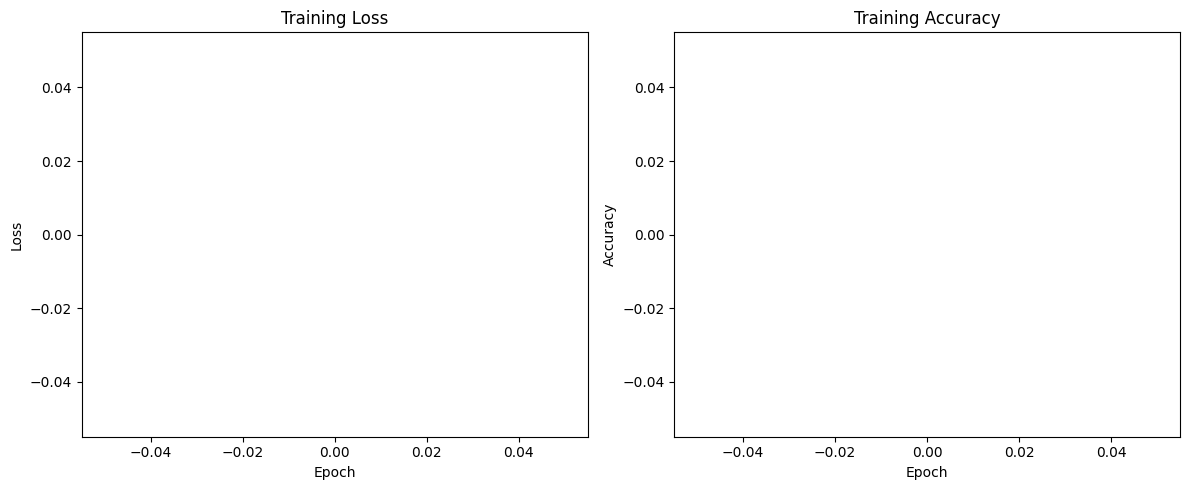

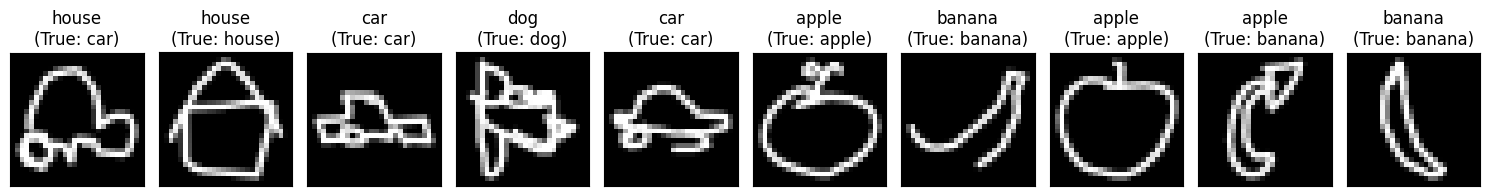

Training complete. You can view the TensorBoard logs by running:
tensorboard --logdir=runs


In [5]:
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
from torch.optim.lr_scheduler import StepLR

writer = SummaryWriter('runs/quickdraw_experiment')

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Lists to store metrics for plotting
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Log to TensorBoard every 100 batches
            if i % 100 == 99:
                writer.add_scalar('training loss', running_loss / 100, epoch * len(train_loader) + i)
                writer.add_scalar('accuracy', 100. * correct / total, epoch * len(train_loader) + i)
                running_loss = 0.0
        
        
        train_accuracy = correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_accuracy = val_correct / val_total
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Log to TensorBoard
        writer.add_scalars('Loss', {'train': running_loss/len(train_loader), 
                                    'val': val_loss/len(val_loader)}, epoch)
        writer.add_scalars('Accuracy', {'train': train_accuracy, 
                                        'val': val_accuracy}, epoch)
        
        # Log model parameters
        for name, param in model.named_parameters():
            writer.add_histogram(name, param, epoch)
            writer.add_histogram(f'{name}.grad', param.grad, epoch)
    
    writer.close()
    
    return train_losses, train_accuracies

# Train the model
model = SimpleNN(input_size=28*28, hidden_size=256, num_classes=len(categories))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Initialize the scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
train_losses, train_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

# Log the plot to TensorBoard
writer = SummaryWriter('runs/quickdraw_experiment')
writer.add_figure('training_metrics', plt.gcf())
writer.close()

# Visualize some predictions
def visualize_predictions(model, dataloader, num_images=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)[:num_images]
    labels = labels[:num_images]
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    fig = plt.figure(figsize=(15, 3))
    for i in range(num_images):
        ax = fig.add_subplot(1, num_images, i+1, xticks=[], yticks=[])
        ax.imshow(images[i].cpu().squeeze(), cmap='gray')
        ax.set_title(f"{categories[predicted[i]]}\n(True: {categories[labels[i]]})")
    
    plt.tight_layout()
    plt.savefig('predictions.png')
    plt.show()
    
    # Log the predictions to TensorBoard
    writer = SummaryWriter('runs/quickdraw_experiment')
    writer.add_figure('predictions', plt.gcf())
    writer.close()

visualize_predictions(model, train_loader)

print("Training complete. You can view the TensorBoard logs by running:")
print("tensorboard --logdir=runs")